In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

rf = pd.read_excel("/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignments/Risk_Factors.xlsx")
industry_p = pd.read_excel("/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignments/Industry_Portfolios.xlsx")
market_p = pd.read_excel("/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignments/Market_Portfolio.xlsx")
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
industry_p = industry_p.drop(columns={"Date"})
market_p = market_p.drop(columns={"Date"})

In [6]:
def FF3Factor(data_portfolio, data_market, risk_factors):
    data_portfolio = data_portfolio.copy()
    data_portfolio.index = risk_factors.index
    data_factors = risk_factors[['Rm-Rf', 'SMB', 'HML']]
    array_rf = risk_factors['Rf']
    y = data_portfolio.subtract(array_rf, axis=0)
    x = data_factors.values
    c = len(y.columns)
    models = []
    r_sq = []
    alphas = []
    betas_rm_rf = []
    betas_smb = []
    betas_hml = []

    for i in range(c):
        model = LinearRegression().fit(x, y.iloc[:, i])
        models.append(model)
        r_sq.append(model.score(x, y.iloc[:, i]))
        alphas.append(model.intercept_)
        betas_rm_rf.append(model.coef_[0])
        betas_smb.append(model.coef_[1])
        betas_hml.append(model.coef_[2])
        
    FF_table = pd.DataFrame({
        'Alpha': alphas,
        'Beta (Rm-Rf)': betas_rm_rf,
        'Beta (SMB)': betas_smb,
        'Beta (HML)': betas_hml,
        'R-squared': r_sq
    }, index=y.columns)

    return FF_table


def calculate_performance_metrics(excess_returns, risk_factors, capm_betas, ff_alphas):
    performance_metrics = pd.DataFrame(columns=['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio',
                                                "Jensen's Alpha", "FF Three-Factor Alpha"],
                                       index=excess_returns.columns)

    mean_excess_returns = excess_returns.mean()
    std_devs = excess_returns.std(ddof=1)
    semi_variances = {}
    for industry in excess_returns.columns:
        downside_returns = excess_returns[industry][excess_returns[industry] < 0]
        if len(downside_returns) > 0:
            semi_variance = (downside_returns ** 2).sum() / len(excess_returns)
            semi_variances[industry] = semi_variance
        else:
            semi_variances[industry] = np.nan

    semi_std_devs = {industry: np.sqrt(semi_variances[industry]) for industry in semi_variances}
    sharpe_ratios = mean_excess_returns / std_devs
    sortino_ratios = mean_excess_returns / pd.Series(semi_std_devs)
    treynor_ratios = mean_excess_returns / capm_betas
    jensens_alphas = {}
    for industry in excess_returns.columns:
        Y = excess_returns[industry]
        X = sm.add_constant(risk_factors['Rm-Rf'])
        capm_model = sm.OLS(Y, X).fit()
        jensens_alphas[industry] = capm_model.params['const']
        
    performance_metrics['Sharpe Ratio'] = sharpe_ratios
    performance_metrics['Sortino Ratio'] = sortino_ratios
    performance_metrics['Treynor Ratio'] = treynor_ratios
    performance_metrics["Jensen's Alpha"] = pd.Series(jensens_alphas)
    performance_metrics["FF Three-Factor Alpha"] = ff_alphas

    return performance_metrics.astype(float)

def capm_alpha_beta(industry_returns, market_returns, risk_free):
    excess_returns = industry_returns.subtract(risk_free, axis=0)
    market_excess_returns = market_returns.subtract(risk_free, axis=0)
    market_excess_returns = pd.DataFrame(market_excess_returns)
    market_excess_returns.columns = ['Rm_minus_Rf']
    
    capm_betas = pd.Series(index=excess_returns.columns, dtype=float)
    jensens_alphas = pd.Series(index=excess_returns.columns, dtype=float)
    
    for industry in excess_returns.columns:
            Y = excess_returns[industry]
            data = pd.concat([Y, market_excess_returns], axis=1).dropna()
            X = sm.add_constant(data['Rm_minus_Rf'])
            Y = data[industry]
            capm_model = sm.OLS(Y, X).fit()
            capm_betas[industry] = capm_model.params['Rm_minus_Rf']
            jensens_alphas[industry] = capm_model.params['const']

    return excess_returns, capm_betas, jensens_alphas

def plot_performance_metrics(performance_metrics, metrics_to_plot=None):
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        performance_metrics[metric].plot(kind='bar')
        plt.title(f'{metric} for Industry Portfolios')
        plt.ylabel(metric)
        plt.xlabel('Industry Portfolios')
        plt.tight_layout()
        plt.show()


In [21]:
ff_table = FF3Factor(data_portfolio=industry_p, data_market=market_p, risk_factors=rf)
industry_excess_returns, capm_betas, jensens_alpha = capm_alpha_beta(industry_returns=industry_p, market_returns=market_p, risk_free=rf["Rf"])
performance_metrics = calculate_performance_metrics(excess_returns=industry_excess_returns,\
                                                    risk_factors=rf, capm_betas=capm_betas,\
                                                    ff_alphas=ff_table["Alpha"])

ff_table.drop(columns={"R-squared"}, inplace=True)
ff_table

,Alpha,Beta (Rm-Rf),Beta (SMB),Beta (HML)
NoDur,0.386704,0.712134,-0.229102,-0.023342
Durbl,-0.474342,1.447452,0.670878,0.240949
Manuf,0.153285,1.142282,0.087388,0.027727
Enrgy,0.523007,1.028354,-0.259360,-0.008158
HiTec,-0.065979,1.152803,0.335674,-0.556947
Telcm,0.200724,0.924137,-0.080299,-0.019063
Shops,0.255941,0.770227,0.280191,-0.039080
Hlth,0.257472,0.751976,-0.212655,-0.143765
Utils,0.474411,0.631827,-0.387961,-0.016881
Other,-0.404412,1.123473,-0.061676,0.547325


In [23]:
performance_metrics

,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Jensen's Alpha,FF Three-Factor Alpha
NoDur,0.231099,0.350804,1.186372,0.369717,0.386704
Durbl,0.072356,0.111967,0.367463,-0.417903,-0.474342
Manuf,0.166616,0.241260,0.758251,0.160494,0.153285
Enrgy,0.181708,0.273612,1.143330,0.504485,0.523007
HiTec,0.118552,0.170620,0.564295,-0.064024,-0.065979
Telcm,0.169064,0.244940,0.836363,0.194348,0.200724
Shops,0.191753,0.293032,0.951258,0.274093,0.255941
Hlth,0.172529,0.270294,0.971435,0.236968,0.257472
Utils,0.210948,0.290044,1.452334,0.446523,0.474411
Other,0.064693,0.087351,0.299781,-0.387508,-0.404412


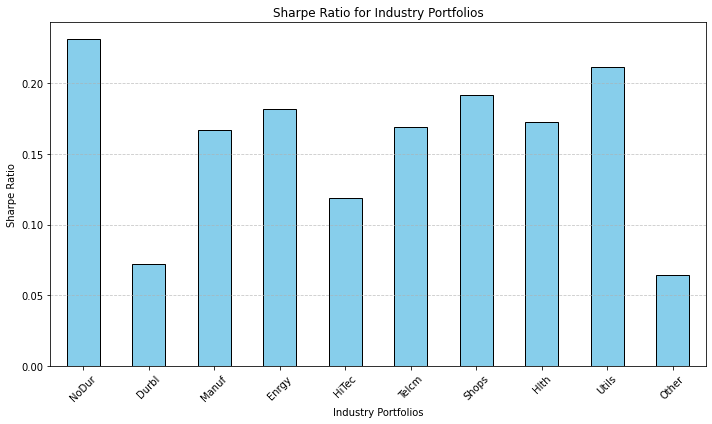

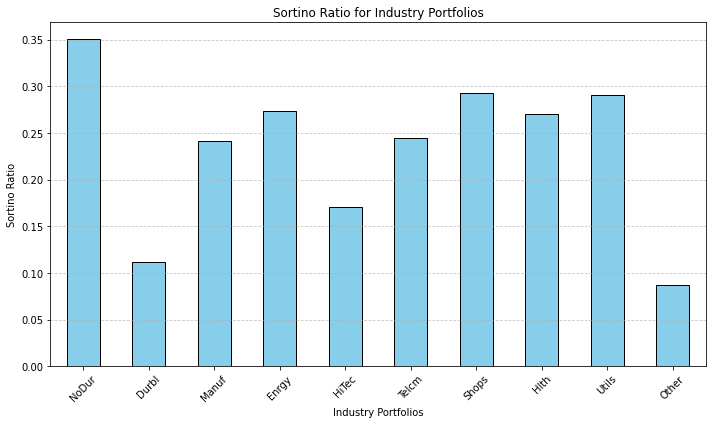

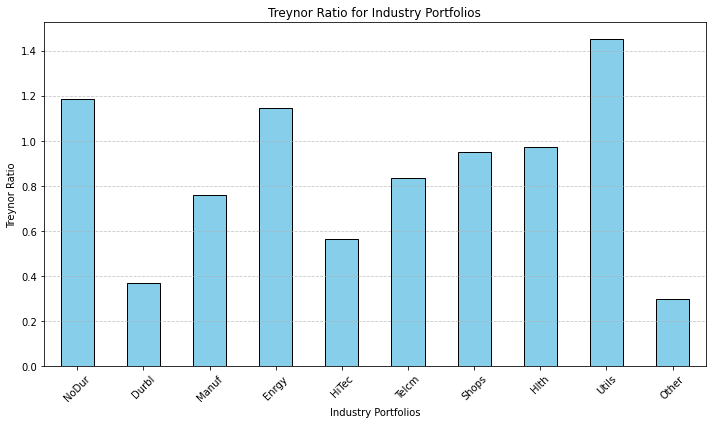

In [22]:
metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    performance_metrics[metric].plot(kind='bar', color="skyblue", edgecolor='black')
    plt.title(f'{metric} for Industry Portfolios')
    plt.ylabel(metric)
    plt.xlabel('Industry Portfolios')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Explanation of the 3 Ratios


**Sharpe Ratio**:

- The Sharpe Ratio evaluates how well an investment compensates an investor for the risk taken. It considers both the returns and the total volatility of those returns. It measures the excess return over a risk-free rate per unit of total risk (Systematic and Unsystematic). Economically, it helps investors understand whether the returns are due to smart investment choices or excessive risk-taking. A higher Sharpe Ratio indicates a more efficient risk-adjusted returns. 
- In terms of pricing implications, investments with higher Sharpe Ratios are generally more attractive and sought after by investors, this often leads to increased demand and higher prices, as investors are more willing to pay for an asset that offers better returns for the level of risk assumed.



**Sortino Ratio**: 

- The Sortino Ratio is similar to the Sharpe Ratio but focuses only on downside risk—the volatility of negative returns—rather than total volatility. It measures the excess return over a risk-free rate per unit of negative (downside) risk. Economically, it provides a more accurate assessment for investors who are primarily concerned with the risk of losses rather than overall fluctuations. 
- A higher Sortino Ratio suggests that an investment offers better returns for the amount of undesirable risk taken. Pricing implications include the potential for such investments to be more highly valued by risk-averse investors, which could drive up their prices due to the perceived better management of downside risk.




**Treynor Ratio**: 

- The Treynor Ratio assesses how much excess return an investment generates per unit of market risk, focusing solely on systematic risk (the risk inherent to the entire market or market segment). It evaluates an investment's performance relative to its exposure to market movements. Economically, it helps investors determine how effectively an investment compensates them for market risk taken, which is especially relevant in diversified portfolios where unsystematic risk is minimized. 
- A higher Treynor Ratio indicates more efficient use of market risk. The pricing implications are that assets with higher Treynor Ratios may become more sought after by investors seeking to maximize returns relative to market risk, potentially increasing their market prices.